In [2]:
from pde import NeuralNet, LinearQuadraticRegulator, GenerateData, NonLinear, CuckerSmale
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.linalg

# Linear case of 1 particule Cucker Smale example (2D)

In [49]:
A = np.array([[0, 1], [0, 0]])
B = np.block( [[0.], [1.]] )
Q = 1 / 1 * np.eye(2, 2)
R = 1 / 1 * np.eye(1, 1)

In [50]:
P = scipy.linalg.solve_continuous_are(A, B, Q, R)
P

array([[1.73205081, 1.        ],
       [1.        , 1.73205081]])

In [51]:
from itertools import product
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

X, Y = np.meshgrid(x, y)
xinput = np.array([barx_i for barx_i in list( product(x, y) )])

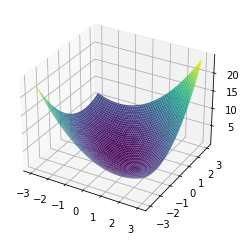

In [52]:
Z = 0.5 * np.einsum('ni, ij, nj -> n', xinput, P, xinput).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

In [53]:
import scipy.linalg
n_samples = 1
T = 10
dt = 0.1
barx = np.array([[1.8, 0.5]])

def compute_trajectories():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = P @ barx_i
            baru = - B.T @ gradV
            
            # compute the dynamics
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u

In [54]:
resu, save_u = compute_trajectories()

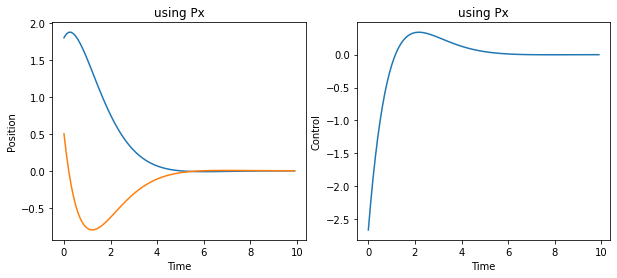

In [55]:
resu, save_u = compute_trajectories()

fig, axs = plt.subplots(1, 2,figsize=(10, 4))
ax = axs[0]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), resu[sample][:, 0])
    ax.plot(np.arange(0, T, dt), resu[sample][:, 1])
ax.set_ylabel('Position')
ax.set_xlabel('Time')
ax.set_title('using Px');

ax = axs[1]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), save_u[sample][:, 0])
ax.set_ylabel('Control')
ax.set_xlabel('Time')
ax.set_title('using Px');

In [56]:
def computeValueFunction(new_barx_i):
    save_barx_i = np.zeros( (100, 2) )
    save_u_i = np.zeros( (100, 1) )
    
    for i, t in enumerate( np.arange(0, T, dt) ):
        save_barx_i[i] = new_barx_i

        # compute the control
        barx_i = new_barx_i
        # gradV = np.array( [v1_deriv(barx_i[0], barx_i[1]), v2_deriv(barx_i[0], barx_i[1])] )
        gradV = P @ barx_i
        baru = - B.T @ gradV
        
        # compute the dynamics
        new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

        save_u_i[i] = baru.item()
        
    # compute the value function
    v = 0.5 * np.trapz(y=save_barx_i[:, 0]**2, dx=dt) + 0.5 * np.trapz(y=save_barx_i[:, 1]**2, dx=dt) + 0.5 * np.trapz(y=np.squeeze( save_u_i**2 ), dx=dt)

    return v

In [57]:
total_v = np.zeros((100, 100))
for i, x1 in enumerate( np.linspace(-3, 3, 100) ):
    for j, x2 in enumerate( np.linspace(-3, 3, 100) ):
        total_v[i, j] = computeValueFunction( np.array([x1, x2]) )

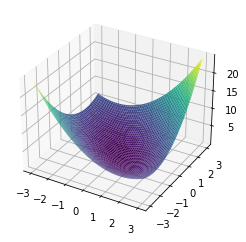

In [58]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_v, cmap='viridis');

# Non linearity
We can add a coefficient epsilon in front of the non linearity and see how the above evolves
\begin{bmatrix} 
            0 & 1  \\
           \epsilon x^2 & 0
\end{bmatrix}
B = [0, 1]T 

R = Q = I

In [3]:
epsilon = 0.

gradfx = lambda x, y: (epsilon**2 * x**4 + 1)**0.5 * (1 + 2*(epsilon * x**2 + (epsilon**2 * x**4 + 1)**0.5))**0.5 * x + (epsilon * x**2 + (epsilon**2 * x**4 + 1)**0.5) * y
gradfy = lambda x, y: (epsilon * x**2 + (epsilon**2 * x**4 + 1)**0.5) * x + (1 + 2*( epsilon * x**2 + (epsilon**2 * x**4 + 1)**0.5))**0.5 * y

In [239]:
import scipy.linalg
n_samples = 1
T = 10
dt = 0.1
barx = np.random.random( (n_samples, 2) )
barx = np.array([[0.8, 0.5], [0.3, -0.7]])

B = np.array([[0], [1]])
Q = np.eye(2, 2)
R = np.eye(2, 2)

def compute_trajectories():
    resu = {}
    save_u = {}
    for sample in range(n_samples):
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2) )
        save_u_i = np.zeros( (100, 1) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            save_barx_i[i] = new_barx_i

            # compute the control
            barx_i = new_barx_i
            gradV = np.array( [0, gradfy(barx_i[0], barx_i[1])] )
            baru = - B.T @ gradV
            
            # compute the dynamics
            A = np.array([[0, 1], [epsilon * barx_i[0]**2, 0]])
            new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

            save_u_i[i] = baru.item()
            
        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
    return resu, save_u

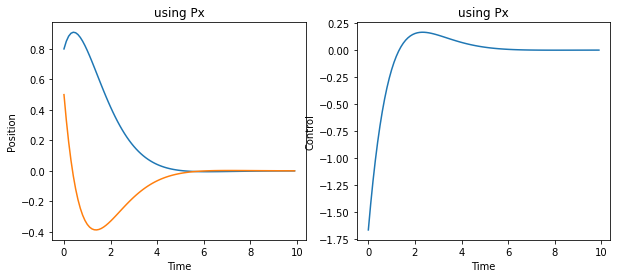

In [240]:
resu, save_u = compute_trajectories()

fig, axs = plt.subplots(1, 2,figsize=(10, 4))
ax = axs[0]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), resu[sample][:, 0])
    ax.plot(np.arange(0, T, dt), resu[sample][:, 1])
ax.set_ylabel('Position')
ax.set_xlabel('Time')
ax.set_title('using Px');

ax = axs[1]
for sample in range(n_samples):
    ax.plot(np.arange(0, T, dt), save_u[sample][:, 0])
ax.set_ylabel('Control')
ax.set_xlabel('Time')
ax.set_title('using Px');

In [241]:
def dataValueFunction( x ):
    stackedMatrices = np.zeros((x.shape[0], x.shape[1], x.shape[1]))

    p12 = lambda x: epsilon * x**2 + np.sqrt(epsilon**2 * x**4 + 1)
    p22 = lambda x: np.sqrt( 1 + 2*p12(x) ) 
    p11 = lambda x: (np.sqrt(epsilon**2 * x**4 + 1)) * p22(x)

    stackedMatrices[:, 0, 0] = p11( x[:, 0] )
    stackedMatrices[:, 0, 1] = p12( x[:, 0] )
    stackedMatrices[:, 1, 0] = p12( x[:, 0] )
    stackedMatrices[:, 1, 1] = p22( x[:, 0] )

    productValueFunction = 0.5 * np.einsum('ni, nij, nj -> n', x, stackedMatrices, x).reshape(-1, 1)

    return productValueFunction

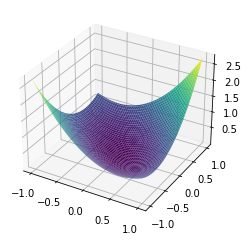

In [242]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

Z = dataValueFunction( torch.tensor( [X.reshape(-1, 1), Y.reshape(-1, 1)] ).squeeze().float().T ).reshape(-1, 100).T

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

In [243]:
def computeValueFunction(new_barx_i):
    save_barx_i = np.zeros( (100, 2) )
    save_u_i = np.zeros( (100, 1) )
    
    for i, t in enumerate( np.arange(0, T, dt) ):
        save_barx_i[i] = new_barx_i

        # compute the control
        barx_i = new_barx_i
        # gradV = np.array( [v1_deriv(barx_i[0], barx_i[1]), v2_deriv(barx_i[0], barx_i[1])] )
        gradV = np.array( [0, gradfy(barx_i[0], barx_i[1])] )
        baru = - B.T @ gradV
        
        # compute the dynamics
        A = np.array([[0, 1], [epsilon * barx_i[0]**2, 0]])
        new_barx_i = barx_i + A @ barx_i * dt + B @ baru * dt

        save_u_i[i] = baru.item()
        
    # compute the value function
    v = 0.5 * np.trapz(y=save_barx_i[:, 0]**2, dx=dt) + 0.5 * np.trapz(y=save_barx_i[:, 1]**2, dx=dt) + 0.5 * np.trapz(y=np.squeeze( save_u_i**2 ), dx=dt)

    return v

In [244]:
total_v = np.zeros((100, 100))
for i, x1 in enumerate( np.linspace(-1, 1, 100) ):
    for j, x2 in enumerate( np.linspace(-1, 1, 100) ):
        total_v[i, j] = computeValueFunction( np.array([x1, x2]) )

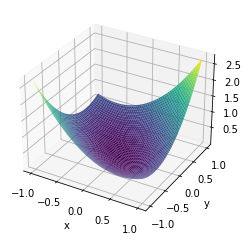

In [245]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_v, cmap='viridis');
ax.set_xlabel('x')
ax.set_ylabel('y');

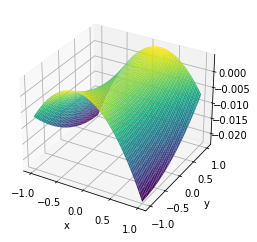

In [246]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_v - Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y');
#ax.set_zlim(0, 1)

In [247]:
gradvy, gradvx = np.gradient( total_v, .02, .02 )

## Make sure the solution obtained satisfies the Hamilton Jacobi equation

In [4]:
# setup problem
B = np.array( [[0., 0], [0, 1.]] )
Q = 1 / 1 * np.eye(2, 2)
R = 1 / 1 * np.eye(1, 1)

In [5]:
epsilon = 1e-10

# compute grad_approx = gradV
p12 = lambda x: epsilon * x**2 + np.sqrt(epsilon**2 * x**4 + 1)
p22 = lambda x: np.sqrt( 1 + 2*p12(x) ) 
p11 = lambda x: (np.sqrt(epsilon**2 * x**4 + 1)) * p22(x)

gradfx_approx = lambda x, y: p11(x)*x + p12(x)*y
gradfy_approx = lambda x, y: p12(x)*x + p22(x)*y 

# compute real gradV based on SDRE matrix P
p12_deriv = lambda x: 2 * epsilon * x * ( 1 + epsilon * x**2 / np.sqrt(epsilon**2 * x**4 + 1) )
p22_deriv = lambda x: p12_deriv(x) / p22(x)
p11_deriv = lambda x: 2 * epsilon**2 * x**3 / np.sqrt(epsilon**2 * x**4 + 1) * p22(x) + np.sqrt(1 + epsilon**2 * x**4) * p22_deriv(x)

gradfx = lambda x, y: 0.5 * ( p11_deriv(x) * x**2 + 2 * x * p11(x) + 2*p12_deriv(x) * x * y + 2*p12(x) * y + y**2 * p22_deriv(x) )
gradfy = lambda x, y: p12(x) * x + p22(x) * y


In [6]:
def computeFxTerm(x, gradV):
    # we need to build a stacked matrix because A depends on x
    stackedMatrices = np.zeros((x.shape[0], x.shape[1], x.shape[1]))
    stackedMatrices[:, 0, 1] = 1 
    stackedMatrices[:, 1, 0] = epsilon * x[:, 0]**2
    productFx = np.einsum('ni, nij, nj -> n', gradV, stackedMatrices, x).reshape(-1, 1)
    return productFx

def computeGxTerm(gradV):
    beta = 0.5
    productGx = -1. / (4 * beta) * np.einsum('ni, ij, nj -> n', gradV, B, gradV).reshape(-1, 1)
    return productGx 

def computeLxTerm(x):
    productLx = 0.5 * np.einsum('ni, ij, nj -> n', x, Q, x).reshape(-1, 1)
    return productLx

def computeHamiltonJacobi(x, gradV):
    return computeFxTerm(x, gradV) + computeGxTerm(gradV) + computeLxTerm(x)


In [7]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

xinput = np.array( [X, Y] ).reshape(2, -1).T

In [8]:
gradV = np.zeros(shape=(10000, 2))
gradV_approx = np.zeros(shape=(10000, 2))
for i, xi in enumerate( xinput ):
    gradV[i] = np.array([gradfx(xi[0], xi[1]), gradfy(xi[0], xi[1])])
    gradV_approx[i] = np.array([gradfx_approx(xi[0], xi[1]), gradfy_approx(xi[0], xi[1])])

In [9]:
print( gradV[:5])
print( gradV_approx[:5]) 

[[-2.73205081 -2.73205081]
 [-2.69705988 -2.71184879]
 [-2.66206896 -2.69164677]
 [-2.62707803 -2.67144475]
 [-2.59208711 -2.65124273]]
[[-2.73205081 -2.73205081]
 [-2.69705988 -2.71184879]
 [-2.66206896 -2.69164677]
 [-2.62707803 -2.67144475]
 [-2.59208711 -2.65124273]]


In [10]:
print( 'Exact grad: %.2e' %computeHamiltonJacobi( xinput, gradV ).mean())
print( 'GradV = Px: %.2e' %computeHamiltonJacobi( xinput, gradV_approx ).mean())

Exact grad: 2.31e-11
GradV = Px: 1.50e-19


In [ ]:
# the exact grad violates the Hamilton Jacobi equation
# the gradV = Px violates the gradient principles and relations between partial derivatives
# how do you evaluate how much you violate the gradient equation?

# but its relevant to apply this for the neural network as it does not violate the Hamilton Jacobi 
# so when the NN trains on the SDRE it gives the 'exact gradient' solution, hence the discrepency.

In [11]:
# plot the discrepency wrt to epsilon?
def computeDiscrepency(epsilon, xinput):

    # compute grad_approx = gradV
    p12 = lambda x: epsilon * x**2 + np.sqrt(epsilon**2 * x**4 + 1)
    p22 = lambda x: np.sqrt( 1 + 2*p12(x) ) 
    p11 = lambda x: (np.sqrt(epsilon**2 * x**4 + 1)) * p22(x)

    # compute real gradV based on SDRE matrix P
    p12_deriv = lambda x: 2 * epsilon * x * ( 1 + epsilon * x**2 / np.sqrt(epsilon**2 * x**4 + 1) )
    p22_deriv = lambda x: p12_deriv(x) / p22(x)
    p11_deriv = lambda x: 2 * epsilon**2 * x**3 / np.sqrt(epsilon**2 * x**4 + 1) * p22(x) + np.sqrt(1 + epsilon**2 * x**4) * p22_deriv(x)

    gradfx = lambda x, y: 0.5 * ( p11_deriv(x) * x**2 + 2 * x * p11(x) + 2*p12_deriv(x) * x * y + 2*p12(x) * y + y**2 * p22_deriv(x) )
    gradfy = lambda x, y: p12(x) * x + p22(x) * y

    gradV = np.zeros(shape=(10000, 2))
    for i, xi in enumerate( xinput ):
        gradV[i] = np.array([gradfx(xi[0], xi[1]), gradfy(xi[0], xi[1])])

    def computeFxTerm(x, gradV):
        # we need to build a stacked matrix because A depends on x
        stackedMatrices = np.zeros((x.shape[0], x.shape[1], x.shape[1]))
        stackedMatrices[:, 0, 1] = 1 
        stackedMatrices[:, 1, 0] = epsilon * x[:, 0]**2
        productFx = np.einsum('ni, nij, nj -> n', gradV, stackedMatrices, x).reshape(-1, 1)
        return productFx

    def computeGxTerm(gradV):
        beta = 0.5
        productGx = -1. / (4 * beta) * np.einsum('ni, ij, nj -> n', gradV, B, gradV).reshape(-1, 1)
        return productGx 

    def computeLxTerm(x):
        productLx = 0.5 * np.einsum('ni, ij, nj -> n', x, Q, x).reshape(-1, 1)
        return productLx

    def computeHamiltonJacobi(x, gradV):
        return computeFxTerm(x, gradV) + computeGxTerm(gradV) + computeLxTerm(x)


    return computeHamiltonJacobi( xinput, gradV ).mean()

In [12]:
range_epsilon = [1e-3, 1e-2, 0.1, 1, 10]
range_discrepency = [computeDiscrepency(epsilon, xinput) for epsilon in range_epsilon]

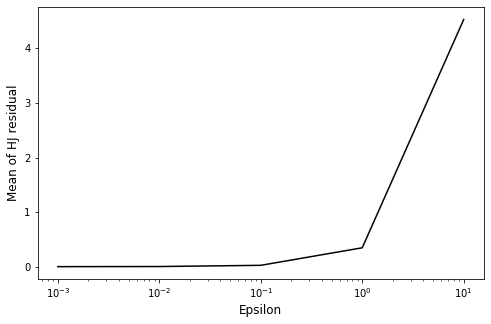

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range_epsilon, range_discrepency, color='black')
ax.set_xscale('log')
ax.set_xlabel('Epsilon', fontsize=12)
ax.set_ylabel('Mean of HJ residual', fontsize=12);

In [21]:
np.savetxt( 'feb_exp_non_linear_discrepency.csv',
    np.vstack( [
        np.arange(5),
        range_epsilon,
        range_discrepency
    ]).T,
    delimiter=',',
    fmt='%.6f' )